In [36]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from torchvision.datasets import SVHN, CIFAR10, CIFAR100

In [37]:
def load_dataset(dataset_name):
    if dataset_name == 'CIFAR10':
        trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    elif dataset_name == 'CIFAR100':
        trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
        testset = CIFAR100(root='./data', train=False, download=True, transform=transform)
        classes = trainset.classes  # CIFAR-100 includes 100 classes
    elif dataset_name == 'SVHN':
        trainset = SVHN(root='./data', split='train', download=True, transform=transform)
        testset = SVHN(root='./data', split='test', download=True, transform=transform)
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')  # SVHN has 10 classes

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    return trainloader, testloader, classes


In [34]:
def load_dataset(dataset_name):
    if dataset_name == 'CIFAR10':
        trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    elif dataset_name == 'CIFAR100':
        trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
        testset = CIFAR100(root='./data', train=False, download=True, transform=transform)
        classes = trainset.classes
    elif dataset_name == 'SVHN':
        trainset = SVHN(root='./data', split='train', download=True, transform=transform)
        testset = SVHN(root='./data', split='test', download=True, transform=transform)
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')  # SVHN has 10 classes

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    return trainloader, testloader, classes

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_name = input("Please select dataset (CIFAR10, CIFAR100, SVHN): ").upper()
trainloader, testloader, classes = load_dataset(dataset_name)

Please select dataset (CIFAR10, CIFAR100, SVHN): svhn


100%|██████████| 182040794/182040794 [00:28<00:00, 6345014.53it/s] 


100%|██████████| 64275384/64275384 [00:14<00:00, 4462853.48it/s]


In [40]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
def train_self_paced(epoch):
    global percentile_start
    net_spl.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_spl.zero_grad()
        outputs = net_spl(inputs)
        losses = criterion(outputs, labels)
        lambda_ = np.percentile(losses.detach().cpu().numpy(), percentile_start)
        easy_samples = losses < lambda_
        if easy_samples.sum() == 0:
            continue

        loss = losses[easy_samples].mean()
        loss.backward()
        optimizer_spl.step()
    percentile_start += percentile_increment
    print(f'SPL - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Percentile: {percentile_start}%')


In [13]:
def train_no_spl(epoch):
    net_no_spl.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer_no_spl.zero_grad()

        outputs = net_no_spl(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer_no_spl.step()

    print(f'No SPL - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




In [14]:
def evaluate_and_precision(net, model_name):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision_per_class = precision_score(all_labels, all_preds, average=None)
    print(f'Precision per class for {model_name}: {precision_per_class}')
    return precision_per_class



In [43]:
def plot_precision(precision_spl, precision_no_spl, classes):
    bar_width = 0.35
    index = np.arange(len(classes))

    plt.bar(index, precision_spl, bar_width, label='SPL')
    plt.bar(index + bar_width, precision_no_spl, bar_width, label='No SPL')

    plt.xlabel('Classes')
    plt.ylabel('Precision')
    plt.title(f'Comparison of Precision per Class for SPL and No SPL ({dataset_name})')
    plt.xticks(index + bar_width / 2, classes, rotation=90 if len(classes) > 10 else 45)
    plt.legend()
    plt.tight_layout()
    plt.show()

SPL - Epoch [1/10], Loss: 0.3325, Percentile: 20%
No SPL - Epoch [1/10], Loss: 2.2026
SPL - Epoch [2/10], Loss: 0.8285, Percentile: 30%
No SPL - Epoch [2/10], Loss: 2.1853
SPL - Epoch [3/10], Loss: 0.6396, Percentile: 40%
No SPL - Epoch [3/10], Loss: 2.2071
SPL - Epoch [4/10], Loss: 0.1037, Percentile: 50%
No SPL - Epoch [4/10], Loss: 1.4686
SPL - Epoch [5/10], Loss: 0.1939, Percentile: 60%
No SPL - Epoch [5/10], Loss: 0.9666
SPL - Epoch [6/10], Loss: 0.1660, Percentile: 70%
No SPL - Epoch [6/10], Loss: 0.7545
SPL - Epoch [7/10], Loss: 0.3731, Percentile: 80%
No SPL - Epoch [7/10], Loss: 0.4883
SPL - Epoch [8/10], Loss: 0.2959, Percentile: 90%
No SPL - Epoch [8/10], Loss: 0.3662
SPL - Epoch [9/10], Loss: 0.2505, Percentile: 100%
No SPL - Epoch [9/10], Loss: 0.5513
SPL - Epoch [10/10], Loss: 0.5114, Percentile: 110%
No SPL - Epoch [10/10], Loss: 0.6820
Precision per class for SPL: [0.75695217 0.89930762 0.87539242 0.7687665  0.87375    0.90140845
 0.74296991 0.80781912 0.73625609 0.5024

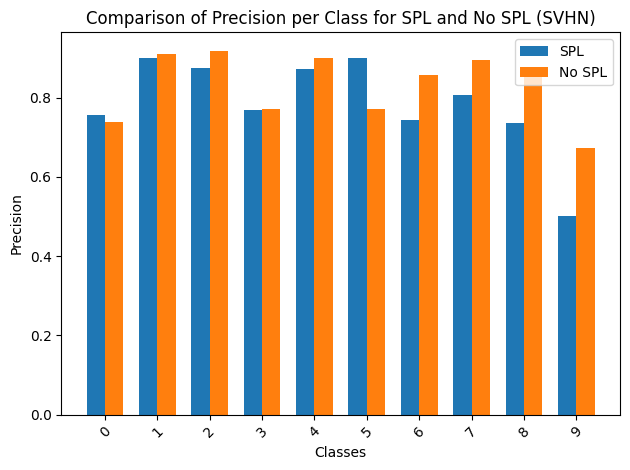

In [42]:
num_classes = len(classes)


net_spl = SimpleCNN(num_classes)
net_no_spl = SimpleCNN(num_classes)


criterion = nn.CrossEntropyLoss(reduction='none')
optimizer_spl = optim.SGD(net_spl.parameters(), lr=0.001, momentum=0.9)
optimizer_no_spl = optim.SGD(net_no_spl.parameters(), lr=0.001, momentum=0.9)


percentile_start = 0
percentile_increment = 10
num_epochs = 10


for epoch in range(num_epochs):
    train_self_paced(epoch)
    train_no_spl(epoch)


precision_spl = evaluate_and_precision(net_spl, "SPL")
precision_no_spl = evaluate_and_precision(net_no_spl, "No SPL")

plot_precision(precision_spl, precision_no_spl, classes)